# 🤖 02 - Pelatihan Model CLSTM untuk Prediksi Harga Saham ANTM

Notebook ini memuat proses pelatihan model Convolutional Long Short-Term Memory (CLSTM)  
untuk memprediksi harga saham ANTM berdasarkan data historis multivariat yang telah diproses.

## 📂 Load Dataset dari File windowed_antm.npz

In [1]:
import numpy as np

# Load dataset hasil windowing
data = np.load('../data/processed/windowed_antm.npz')
X = data['X']          # shape: (samples, timesteps, features)
y = data['y']          # shape: (samples, 1)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (1199, 7, 4)
y shape: (1199, 1)


## ✂️ Split Data ke Train dan Test (80:20)

In [2]:
from sklearn.model_selection import train_test_split

# Split 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test:  {X_test.shape}, {y_test.shape}")

Train: (959, 7, 4), (959, 1)
Test:  (240, 7, 4), (240, 1)


## 🧠 Definisi Arsitektur Model CLSTM

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Input(shape=X_train.shape[1:]),
    Conv1D(filters=64, kernel_size=2, activation='relu'),
    LSTM(64),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 6, 64)          │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,665 (131.50 KB)

 Trainable params: 33,665 (131.50 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# 🔒 Simpan model CLSTM (data ANTM + Eksternal)
model.save("../models/clstm_antm_external.keras")
print("✅ Model berhasil disimpan sebagai clstm_antm_external.keras di folder /models")

✅ Model berhasil disimpan sebagai clstm_antm_external.keras di folder /models


## 🏋️ Training Model dengan EarlyStopping

In [6]:
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0762 - mae: 0.2126 - val_loss: 0.0222 - val_mae: 0.1453
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0039 - mae: 0.0512 - val_loss: 5.9629e-04 - val_mae: 0.0192
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - mae: 0.0295 - val_loss: 4.9814e-04 - val_mae: 0.0175
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012 - mae: 0.0228 - val_loss: 6.3530e-04 - val_mae: 0.0196
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016 - mae: 0.0251 - val_loss: 6.1457e-04 - val_mae: 0.0202
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012 - mae: 0.0238 - val_loss: 5.1687e-04 - val_mae: 0.0183
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012 - mae: 0.0231 - val_loss: 7.5926e-04 - val_mae: 0.0226
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013 - mae: 0.0250 - val_loss: 6.0057e-04 - val_mae: 0.0200
Epoch 9/100
30/30 ━━━━━━━━━━━

## 📏 Evaluasi Model CLSTM
Evaluasi dilakukan menggunakan tiga metrik utama:
- MAE: Mean Absolute Error
- RMSE: Root Mean Squared Error
- MSE: Mean Squared Error

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Prediksi terhadap data uji
y_pred = model.predict(X_test)

# Hitung metrik evaluasi
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"📊 MAE  = {mae:.6f}")
print(f"📊 MSE  = {mse:.6f}")
print(f"📊 RMSE = {rmse:.6f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
📊 MAE  = 0.015816
📊 MSE  = 0.000397
📊 RMSE = 0.019916


## 📉 Visualisasi Prediksi vs Aktual

Grafik berikut membandingkan hasil prediksi model terhadap nilai aktual dari harga saham ANTM (yang telah dinormalisasi).

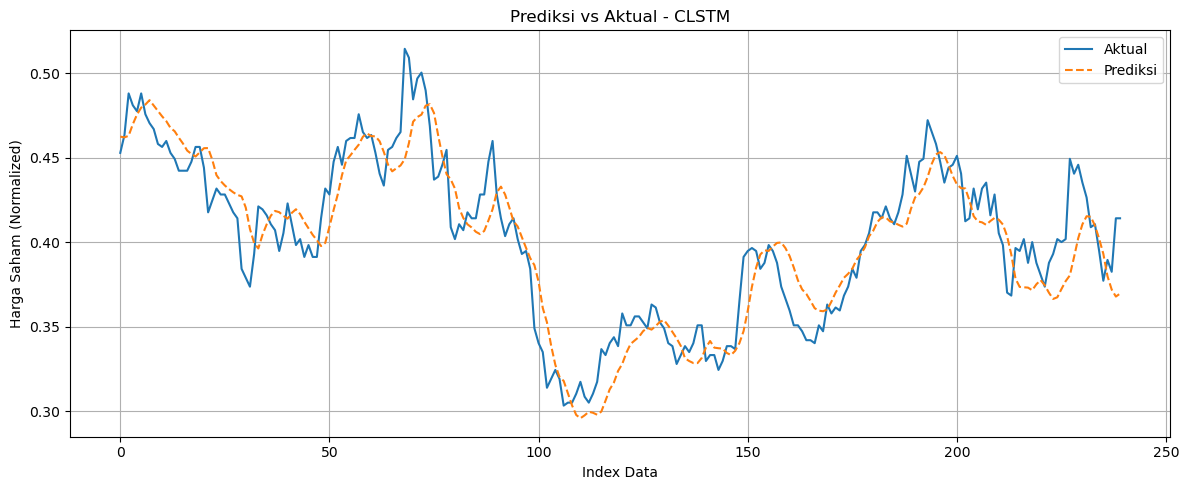

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Aktual')
plt.plot(y_pred, label='Prediksi', linestyle='--')
plt.title('Prediksi vs Aktual - CLSTM')
plt.xlabel('Index Data')
plt.ylabel('Harga Saham (Normalized)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 📈 Grafik Loss Training dan Validation - CLSTM
Menampilkan kurva loss untuk training dan validasi selama proses pelatihan.


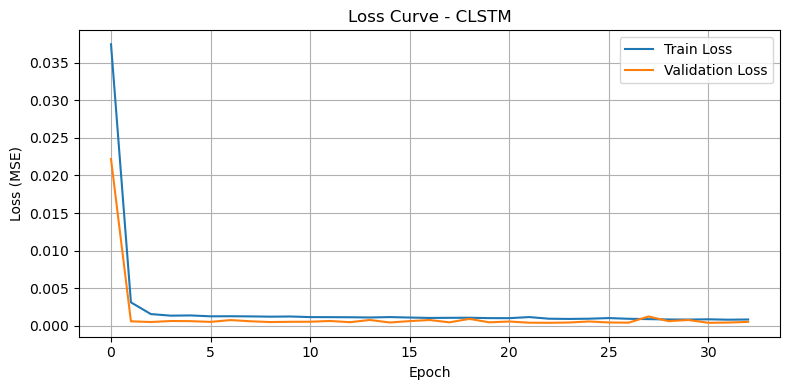

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve - CLSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()